# Varying the Prompt: Effect on Accuracy

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import logging

from mono_multi.setup import (
    variations,
    variations_defaults,
    FIGURES_ROOT_DIR,
)
from mono_multi.utils import (
    get_size_and_it,
    load_risk_scores,
    load_results_overview,
    load_data_if_needed,
    filter_df_by_default_cond,
    prettify_model_name, 
    key_to_model
)

/Users/mgorecki/opt/miniconda3/envs/monoc-py311/lib/python3.11/site-packages/xport/__about__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

FIGURES_PAPER_DIR = FIGURES_ROOT_DIR / "paper-arxiv" / "vary-prompt"
TASKS = ["ACSIncome"]
print("tasks", TASKS)
MODELS = [
    "Qwen--Qwen2.5-7B-Instruct",
    "Qwen--Qwen2.5-72B-Instruct",
    "meta-llama--Meta-Llama-3-8B-Instruct",
    "meta-llama--Meta-Llama-3.3-70B-Instruct",
]
variations

tasks ['ACSIncome']


{'feature_order': ['default', 'rand 1', 'rand 2', 'rand 3', ' reversed'],
 'format': ['bullet', 'text', 'comma'],
 'connector': ['is', '=', ':'],
 'granularity': ['original', 'low'],
 'example_order': ['default', 'rand 1', 'rand 2', 'rand 3', 'reversed'],
 'example_composition': ['10,0', '7,3', 'balanced', '3,7', '0,10']}

## Load available models and variations

In [4]:
try:
    data_all
except NameError:
    print("'data_all' not yet defined")
    data_all = load_data_if_needed(data=None, tasks=TASKS)
else:
    print("Already defined, update if needed.")
    data_all = load_data_if_needed(data=data_all, tasks=TASKS)

'data_all' not yet defined
ACSIncome


## Load predictions

In [ ]:
num_shots = 0
threshold_fitted = True
fit_threshold_for = 'balanced_accuracy'

df = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=False
)
df = df[df["task"].isin(TASKS)]
df = df[df["model"].isin(MODELS)]
df = df[df["threshold_obj"]==fit_threshold_for]

df['predictions_path'] = '/Volumes/mgorecki/monoculture/' + df['predictions_path']
df.shape

(301, 19)

In [6]:
try:
    assert set(TASKS).issubset(
        set(df["task"].unique())
    ), f"Results for all tasks to be analysed have to be available, available are: {list(df['task'].unique())} "
except AssertionError:
    TASKS = list(df["task"].unique())
    logging.warning(f"Reduced TASKS to available tasks: {TASKS}")

In [7]:
risk_scores = (
    df["predictions_path"]
    .apply(load_risk_scores)
    .apply(lambda x: x.squeeze())
    .add_prefix("score_")
)
risk_scores.head()
df_with_riskscores = pd.concat([df, risk_scores], axis=1)
print(df_with_riskscores.shape)
display(df_with_riskscores.head())

df_with_predictions = df_with_riskscores.copy()
model_wise_thresholds = df_with_predictions["threshold"]
df_with_predictions.update(
    df_with_predictions.filter(like="score_").apply(
        lambda col: (col >= model_wise_thresholds).astype(int)
    )
)

(301, 166469)


,task,model,is_inst,threshold_fitted,threshold,threshold_obj,accuracy,balanced_accuracy,bench_hash,num_shots,...,score_944636,score_675237,score_926337,score_2205318,score_3164791,score_43637,score_2494279,score_2989522,score_688458,score_1778641
0,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.033094,balanced_accuracy,0.763755,0.772159,1339497723,0,...,0.025930,0.000011,0.999512,0.000296,0.002183,0.970743,0.000179,0.000031,0.999512,0.990329
1,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.008599,balanced_accuracy,0.775843,0.781488,642741645,0,...,0.002187,0.000046,0.999841,0.000805,0.915033,0.592476,0.000140,0.000231,0.998080,0.530303
2,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.007567,balanced_accuracy,0.760535,0.765280,419256548,0,...,0.007586,0.000075,0.999570,0.000335,0.000802,0.914676,0.000109,0.000097,0.997196,0.973932
3,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.244386,balanced_accuracy,0.776642,0.775290,3671207344,0,...,0.133028,0.000158,0.999842,0.014102,0.982008,0.962724,0.000381,0.000230,0.998081,0.530612
4,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.012454,balanced_accuracy,0.755176,0.767424,2269177329,0,...,0.010969,0.000075,0.999446,0.001506,0.002806,0.939908,0.000433,0.000295,0.998075,0.970641


## Aggregate Level: Check accuracy

In [8]:
models_to_plot = MODELS
models_to_plot = sorted(models_to_plot, key=get_size_and_it)

### Scatter Plot: Fix one variation, others default

In [9]:
df_all_default = filter_df_by_default_cond(df, default_cond=variations_defaults if num_shots==10 else {k:v for k,v in variations_defaults.items() if not k.startswith('example_')}, exclude_key=None)
accs_all_default = df_all_default[["model", "accuracy"]]
assert df_all_default.shape[0] == len(MODELS)

Qwen--Qwen2.5-7B-Instruct
Qwen 2.5 7B (it) 	 0.75	0.005	0.033
meta-llama--Meta-Llama-3-8B-Instruct
Llama 3 8B (it)  	 0.76	0.002	0.010
meta-llama--Meta-Llama-3.3-70B-Instruct
Llama 3.3 70B (it)	 0.78	0.004	0.021
Qwen--Qwen2.5-72B-Instruct
Qwen 2.5 72B (it)	 0.77	0.004	0.024
Qwen--Qwen2.5-7B-Instruct
Qwen 2.5 7B (it) 	 0.76	0.003	0.011
meta-llama--Meta-Llama-3-8B-Instruct
Llama 3 8B (it)  	 0.75	0.006	0.024
meta-llama--Meta-Llama-3.3-70B-Instruct
Llama 3.3 70B (it)	 0.78	0.002	0.010
Qwen--Qwen2.5-72B-Instruct
Qwen 2.5 72B (it)	 0.77	0.003	0.011
Qwen--Qwen2.5-7B-Instruct
Qwen 2.5 7B (it) 	 0.75	0.008	0.029
meta-llama--Meta-Llama-3-8B-Instruct
Llama 3 8B (it)  	 0.74	0.005	0.018
meta-llama--Meta-Llama-3.3-70B-Instruct
Llama 3.3 70B (it)	 0.78	0.003	0.011
Qwen--Qwen2.5-72B-Instruct
Qwen 2.5 72B (it)	 0.78	0.002	0.006
Qwen--Qwen2.5-7B-Instruct
Qwen 2.5 7B (it) 	 0.76	0.006	0.018
meta-llama--Meta-Llama-3-8B-Instruct
Llama 3 8B (it)  	 0.76	0.005	0.014
meta-llama--Meta-Llama-3.3-70B-Instruct


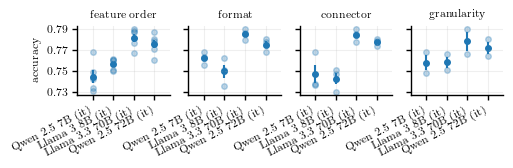

In [10]:
fig_width = plt.rcParams["figure.figsize"][0]
fig_height = 0.3*plt.rcParams['figure.figsize'][1]

zero_shot_variations = [k for k in variations.keys() if ('example' not in k)]
fig, axs = plt.subplots(
    1,
    len(variations.keys()) if num_shots==10 else len(zero_shot_variations),
    figsize=(fig_width, fig_height),
    # , constrained_layout=True,
    sharey=True,
)

plot_all = False
y_max, y_min = 0, 1

for v, vary_variable in enumerate(variations_defaults.keys()):
    if vary_variable not in zero_shot_variations and num_shots == 0:
        continue
    # vary only vary_variable, others default
    df_vary_one = filter_df_by_default_cond(df, exclude_key=vary_variable, default_cond=variations_defaults if num_shots==10 else {k:v for k,v in variations_defaults.items() if not k.startswith('example_')})
    alpha = 0.3

    logging.debug(f"{vary_variable}: {df_vary_one.shape[0]} samples")

    for i, model in enumerate(models_to_plot):
        print(model)
        accs = df_vary_one[df_vary_one["model"] == model]["accuracy"].values

        mean = accs.mean()
        stderr = accs.std() / np.sqrt(len(accs))

        y_max = max(y_max, accs.max())
        y_min = min(y_min, accs.min())

        print(
            f"{prettify_model_name(key_to_model(model)):17}\t {mean:.2f}\t{stderr:.3f}\t{accs.max()-accs.min():.3f}"
        )

        default_acc = accs_all_default[accs_all_default["model"] == model][
            "accuracy"
        ].item()
        axs[v].errorbar(i, mean, yerr=stderr, ls="None", color="C0", label="mean")
        axs[v].scatter(i, mean, color="C0")
        axs[v].scatter([i] * len(accs), accs, color="C0", alpha=alpha)

    axs[v].set_xticks(
        np.arange(len(models_to_plot)),
        [prettify_model_name(key_to_model(model)) for model in models_to_plot],
        rotation=27 if num_shots==0 else 45,
        ha="right",
        va="top",
    )
    axs[v].set_title(vary_variable.replace("prompt_", " " if num_shots==0 else "\n").replace("_", " " if num_shots==0 else "\n"))
    axs[v].set_xmargin(1 / len(models_to_plot))
    axs[v].grid(True, linestyle='-', alpha=0.2)

axs[0].set_ylabel("accuracy")
yticks = np.linspace(y_min, y_max, num=4)
axs[0].set_yticks(yticks, [f"{tick:.2}" for tick in yticks])


file_name = "".join(
    [
        f"performance-{num_shots}-shot-fix-one-default-rest-scatter",
        "_tresh_fitted" if threshold_fitted == 1 else "",
    ]
)

for ending in [".svg", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig4_{file_name}{ending}")
print(file_name)

plt.show()